## 1. Load Trained Model and Validation Data

We begin Day 5 by loading the trained `Learner` object from Day 4. This allows us to evaluate model predictions on the validation set without retraining. We'll also extract the validation DataLoader to visualize inputs and predictions.

In [1]:
# Imports
from fastai.tabular.all import *
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Load the trained Learner
learn = load_learner('../models/block7_model.pkl')

# Preview model and DataLoaders
print(learn.model)
print(learn.dls)

# Grab validation DataLoader
valid_dl = learn.dls.valid

# Confirm number of validation items
len(valid_dl.items)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(5, 4)
    (3): Embedding(3, 3)
    (4): Embedding(5, 4)
    (5): Embedding(4, 3)
    (6-7): 2 x Embedding(3, 3)
    (8): Embedding(4, 3)
    (9): Embedding(13, 7)
    (10): Embedding(32, 11)
    (11): Embedding(4, 3)
    (12): Embedding(53, 15)
    (13): Embedding(8, 5)
    (14-18): 5 x Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=172, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

0

## 2. Model Architecture and Validation Set Status

The loaded model is a `TabularModel` trained on the Rossmann dataset to predict daily store sales. Here's a breakdown of its key architectural components:

### 🔢 Embedding Layers
The model uses **19 embedding layers** corresponding to the 19 categorical variables. Each embedding is sized based on the number of unique categories using this formula:

**embedding dimension = min(50, round(1.6 × (num_categories)^0.56))**

Examples:
- `Store`: 1116 categories → Embedding(1116, 81)
- `DayOfWeek`: 8 categories → Embedding(8, 5)
- Many features with 3 categories → Embedding(3, 3)

These embeddings help the model learn efficient vector representations of categorical variables.

### ⚙️ Fully Connected Layers
After processing the categorical and continuous variables, the model includes:
- Dense layer: 172 inputs → 200 units (with BatchNorm + ReLU)
- Dense layer: 200 → 100 units (with BatchNorm + ReLU)
- Output layer: 100 → 1 (with a `SigmoidRange(0, 41551)` to constrain outputs within realistic sales range)

### 🧪 Continuous Variables
The model processes 7 continuous variables using a `BatchNorm1d(7)` layer for normalization.

### 📉 Validation Set Status
Although the validation DataLoader (`valid_dl`) exists, it appears to be empty (`len(valid_dl.items) == 0`). This likely happened because:
- The validation split wasn’t preserved correctly during saving.
- The underlying `TabularPandas` object was not exported or reattached.

We'll address this in the next step by reloading the data and confirming the validation structure.

In [2]:
# Reload and preprocess from scratch
from fastai.tabular.all import *

# Suppress chained assignment warnings from Pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load and merge datasets
path = Path('../data/rossmann')
df = pd.read_csv(path/'train.csv', low_memory=False)
store_df = pd.read_csv(path/'store.csv')
df = pd.merge(df, store_df, how='left', on='Store')

# Feature engineering
df['Date'] = pd.to_datetime(df['Date'])
add_datepart(df, 'Date', drop=True)

# Define target and features
dep_var = 'Sales'
cat_names = ['Store', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
             'Assortment', 'Promo', 'Promo2', 'PromoInterval', 'Month', 'Day', 'Year', 'Week', 'Dayofweek']
cont_names = ['Customers', 'Open', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
              'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(seed=42)(df)

# Create TabularPandas and DataLoaders
to = TabularPandas(df, procs=procs, cat_names=cat_names,
                   cont_names=cont_names, y_names=dep_var, splits=splits)
dls = to.dataloaders(bs=64)

# Preview one batch
dls.show_batch(max_n=5)

,Store,DayOfWeek,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,Promo2,PromoInterval,Month,Day,Year,Week,Dayofweek,CompetitionDistance_na,CompetitionOpenSinceMonth_na,CompetitionOpenSinceYear_na,Promo2SinceWeek_na,Promo2SinceYear_na,Customers,Open,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,Sales
0,323,2,0,0,d,c,1,1,"Feb,May,Aug,Nov",11,25,2014,48,1,False,False,False,False,False,627.000000,1.0,8400.000097,4.0,2012.0,5.0,2013.0,7566.0
1,795,2,0,0,d,a,0,1,"Mar,Jun,Sept,Dec",6,25,2013,26,1,False,True,True,False,False,320.999997,1.0,510.000127,8.0,2010.0,35.0,2010.0,2762.0
2,761,2,0,0,a,a,0,0,#na#,2,25,2014,9,1,False,False,False,True,True,882.999987,1.0,2390.000060,9.0,2012.0,22.0,2012.0,7116.0
3,1041,3,0,0,c,a,0,1,"Jan,Apr,Jul,Oct",1,21,2015,4,2,False,False,False,False,False,544.000000,1.0,1599.999998,8.0,2013.0,40.0,2014.0,4917.0
4,453,3,0,0,a,c,0,0,#na#,10,2,2013,40,2,False,True,True,True,True,1113.000007,1.0,75860.003316,8.0,2010.0,22.0,2012.0,9121.0
5,94,5,0,0,d,c,0,0,#na#,4,24,2015,17,4,False,True,True,True,True,545.000001,1.0,14620.000275,8.0,2010.0,22.0,2012.0,5525.0
6,116,2,0,0,a,a,1,0,#na#,5,20,2014,21,1,False,False,False,True,True,759.000006,1.0,679.999957,4.0,2013.0,22.0,2012.0,7096.0
7,446,6,0,0,a,a,0,1,"Feb,May,Aug,Nov",7,11,2015,28,5,False,False,False,False,False,313.999987,1.0,339.999837,10.0,2000.0,31.0,2013.0,2440.0
8,157,4,0,1,a,c,1,0,#na#,4,17,2014,16,3,False,False,False,True,True,1253.999985,1.0,2950.000054,10.0,2004.0,22.0,2012.0,11917.0
9,877,5,0,1,a,c,0,0,#na#,5,15,2015,20,4,False,True,True,True,True,894.000002,1.0,29189.999641,8.0,2010.0,22.0,2012.0,6737.0


In [3]:
# Load the trained model again (if not already in memory)
learn = load_learner('../models/block7_model.pkl')

# Replace the model's DataLoaders with the new ones
learn.dls = dls

# Get validation DataLoader and items
valid_dl = dls.valid

# Get predictions and actuals
preds, targs = learn.get_preds(dl=valid_dl)

# Combine into a DataFrame for analysis
results = pd.DataFrame({
    'Predicted': preds.squeeze(-1).numpy(),
    'Actual': targs.squeeze(-1).numpy()
})

# Preview top 10 rows
results.head(10)

,Predicted,Actual
0,4035.842041,4070
1,6686.987793,6675
2,6210.307129,6278
3,4181.239258,4192
4,5225.069824,5897
5,5405.166016,5609
6,4835.359375,4758
7,8122.025391,8121
8,219.392975,0
9,8097.689453,8203


## 4. Visualizing Prediction Error

To better understand model performance, we plot:
- **Residuals**: the difference between predicted and actual sales.
- **Distribution of errors** to identify bias or outliers.

This helps diagnose underfitting, overfitting, or data noise.

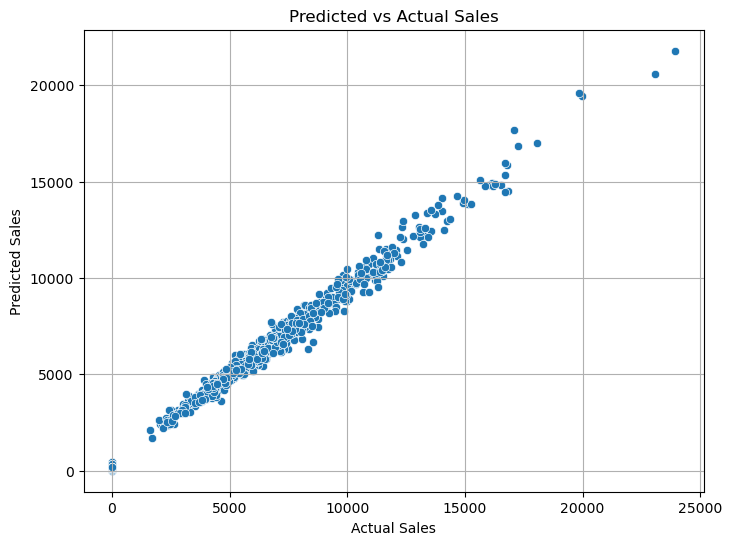

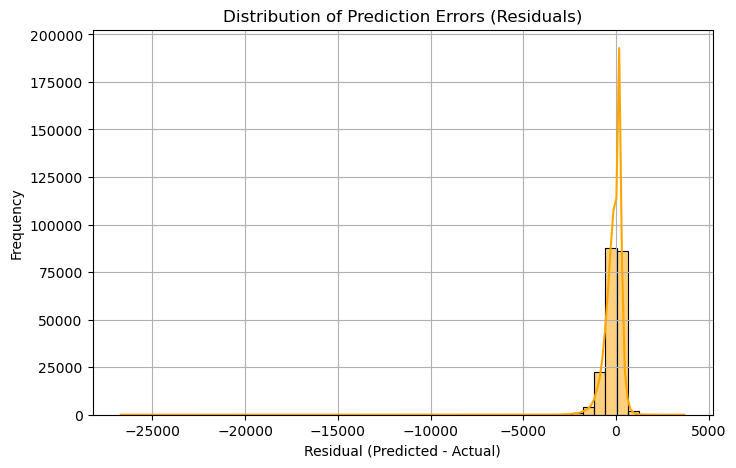

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add residuals to the results
results['Residual'] = results['Predicted'] - results['Actual']

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results.sample(1000))
plt.title('Predicted vs Actual Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.show()

# Residual histogram
plt.figure(figsize=(8, 5))
sns.histplot(results['Residual'], kde=True, bins=50, color='orange')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Residual (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Evaluation: Model Predictions vs Actuals

### Predicted vs Actual Sales

This scatter plot compares the model's predicted sales to the actual sales values from the validation set. A perfect model would place all points along the 45° diagonal line (where predicted = actual). Key observations:

- **Strong linear alignment**: Most points fall close to the diagonal, suggesting that the model has learned the general sales pattern well.
- **Heteroskedasticity**: There is more variance in prediction error as the actual sales values increase — likely due to more volatile sales dynamics in higher-revenue stores.
- **Some outliers**: A few points are distant from the line, indicating cases where the model under- or over-predicted substantially. These might be due to special promotions, closed stores, or holidays not fully captured by the feature set.

---

### Residual Distribution (Predicted - Actual)

This histogram visualizes the distribution of prediction errors (residuals):

- **Tightly centered**: The bulk of residuals are concentrated around 0, indicating most predictions are close to actual values.
- **Slight negative skew**: The tail extends further into negative territory, meaning the model occasionally under-predicts more severely than it over-predicts.
- **Few extreme outliers**: A small number of large errors exist, which may benefit from further analysis (e.g., those few zero-prediction cases for high-sales days).

---

## Takeaway

The model performs well overall, with tight residuals and strong correlation between predictions and targets. Focus areas for improvement may include better handling of:
- edge cases (e.g., stores with erratic sales),
- unmodeled promotions,
- and days with very high or very low traffic.

## Error Analysis: Under- and Over-Predictions

To better understand where our model struggles, we analyze the largest **residuals** — the difference between predicted and actual sales.

- **Under-predictions**: The model predicted significantly less than the true sales.
- **Over-predictions**: The model predicted significantly more than the true sales.

By examining these edge cases, we aim to:
- Detect patterns or conditions where the model fails
- Uncover potential data issues (e.g., anomalies, missing values)
- Reveal opportunities for adding features or refining preprocessing

We'll sort predictions by residual magnitude and display the top 5 extreme cases in each direction.

In [5]:
# Add residuals to the results DataFrame
results['Residual'] = results['Predicted'] - results['Actual']
results['Absolute Error'] = results['Residual'].abs()

# View largest under-predictions
print("Top 5 Under-predictions:")
display(results.sort_values('Residual').head(5))

# View largest over-predictions
print("\nTop 5 Over-predictions:")
display(results.sort_values('Residual', ascending=False).head(5))

Top 5 Under-predictions:


,Predicted,Actual,Residual,Absolute Error
55217,6368.376953,33071,-26702.623047,26702.623047
58110,21751.884766,38037,-16285.115234,16285.115234
185532,4040.187012,20167,-16126.812988,16126.812988
52859,0.000000,15022,-15022.000000,15022.000000
6152,9113.296875,24134,-15020.703125,15020.703125



Top 5 Over-predictions:


,Predicted,Actual,Residual,Absolute Error
11336,5923.407227,2240,3683.407227,3683.407227
149153,27502.513672,23855,3647.513672,3647.513672
37824,17641.343750,14687,2954.343750,2954.343750
45940,4373.770996,1464,2909.770996,2909.770996
52033,7538.559570,4679,2859.559570,2859.559570


### Insights from Top Errors

The top 5 **under-predictions** show the model significantly underestimated high-sales days, missing by as much as ~26,700 units. This may suggest:

- The model failed to capture strong promotional effects or special events.
- There might be rare patterns not well represented in the training data.

The top 5 **over-predictions** had smaller absolute errors (~2,800–3,600 units), typically where the model anticipated more activity than actually occurred. Possible reasons include:

- Stores expected to be open or busy (based on features) were actually closed or underperforming.
- Categorical variables (e.g., Promo, Open) may have missing or misaligned signals.

These discrepancies suggest a need for:
- Better handling of zero sales days (possibly due to store closures).
- Incorporating calendar-based features (e.g., holidays, weekends).
- Additional feature engineering around promotions and competition.

## Merging Top Errors with Original Features

To better understand the model's failure modes, we examine the 10 rows with the highest absolute residuals. By joining these predictions back with the original tabular features, we can identify patterns — such as missed promotions, store types, or date-based anomalies — that may explain poor predictions.

In [6]:
# Compute absolute error
results['Abs_Error'] = results['Residual'].abs()

# Get top 10 rows with highest absolute error
top_errors = results.sort_values(by='Abs_Error', ascending=False).head(10)

# Use their positional indices to pull corresponding feature rows
top_feature_rows = to.items.iloc[top_errors.index]

# Combine features and prediction info
top_error_context = top_feature_rows.copy()
top_error_context['Predicted'] = top_errors['Predicted'].values
top_error_context['Actual'] = top_errors['Actual'].values
top_error_context['Residual'] = top_errors['Residual'].values
top_error_context['Abs_Error'] = top_errors['Abs_Error'].values

# Show features plus predictions
top_error_context[['Predicted', 'Actual', 'Residual', 'Abs_Error'] + cat_names + cont_names]

,Predicted,Actual,Residual,Abs_Error,Store,DayOfWeek,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceYear_na,Promo2SinceWeek_na,Promo2SinceYear_na,Customers,Open,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear
375971,6368.376953,33071,-26702.623047,26702.623047,334,1,1,2,4,3,...,1,1,1,-0.025791,0.452602,-0.179799,0.198467,-0.143394,-0.464015,0.264280
941958,21751.884766,38037,-16285.115234,16285.115234,569,6,1,1,1,1,...,1,2,2,-0.508178,0.452602,-0.530375,0.571376,-0.402191,-0.063670,0.029262
450768,4040.187012,20167,-16126.812988,16126.812988,1094,6,1,1,4,1,...,1,1,1,-0.318668,0.452602,-0.395338,-1.666076,0.503600,1.737882,0.499298
182553,0.000000,15022,-15022.000000,15022.000000,809,3,1,1,1,1,...,1,2,2,0.628877,0.452602,0.953733,0.944284,-1.178583,-0.063670,0.029262
669443,9113.296875,24134,-15020.703125,15020.703125,114,5,1,1,3,1,...,2,1,1,0.068964,0.452602,-0.118772,0.198467,0.115404,2.538572,-0.205755
937550,0.000000,14971,-14971.000000,14971.000000,621,3,1,1,1,1,...,1,2,2,0.185253,0.452602,-0.700470,-0.174442,-0.919786,-0.063670,0.029262
908075,14417.381836,29169,-14751.618164,14751.618164,136,1,1,1,1,3,...,1,1,1,-0.406963,0.452602,-0.418710,1.690102,0.115404,-0.063670,0.029262
990511,2937.484131,17148,-14210.515869,14210.515869,62,4,1,1,1,1,...,2,2,2,0.329539,0.452602,-0.438187,0.198467,0.115404,-0.063670,0.029262
298499,0.000000,13872,-13872.000000,13872.000000,486,7,1,1,1,1,...,2,1,1,-1.363122,-2.209446,-0.403129,0.198467,0.115404,0.837106,0.264280
1001191,0.000000,13692,-13692.000000,13692.000000,707,2,1,1,1,3,...,1,2,2,0.200328,0.452602,-0.327820,-0.174442,-2.472571,-0.063670,0.029262


## Summary of Top Prediction Errors

We now analyze patterns in the top 10 most incorrect predictions:
- Which categorical variables show up disproportionately?
- Are numeric inputs like `Customers` or `CompetitionDistance` unusually high/low?
- Are there missing values in key fields?
This helps surface potential blind spots in model generalization or training data representation.

In [7]:
# 1. Categorical frequency summary
print("Categorical Breakdown:")
for col in cat_names:
    print(f"{col}: {top_error_context[col].value_counts().to_dict()}")
print("\n")

# 2. Continuous value summary
print("Continuous Summary:")
display(top_error_context[cont_names].describe())

# 3. Check missing values
print("Missing Value Count (Top Errors):")
print(top_error_context[cat_names + cont_names].isna().sum())

Categorical Breakdown:
Store: {334: 1, 569: 1, 1094: 1, 809: 1, 114: 1, 621: 1, 136: 1, 62: 1, 486: 1, 707: 1}
DayOfWeek: {1: 2, 6: 2, 3: 2, 5: 1, 4: 1, 7: 1, 2: 1}
StateHoliday: {1: 10}
SchoolHoliday: {1: 9, 2: 1}
StoreType: {1: 7, 4: 2, 3: 1}
Assortment: {1: 7, 3: 3}
Promo: {2: 5, 1: 5}
Promo2: {2: 5, 1: 5}
PromoInterval: {0: 5, 3: 2, 2: 2, 1: 1}
Month: {3: 2, 1: 2, 8: 1, 5: 1, 2: 1, 11: 1, 4: 1, 10: 1}
Day: {24: 2, 8: 2, 4: 1, 9: 1, 18: 1, 13: 1, 26: 1, 15: 1}
Year: {1: 6, 2: 3, 3: 1}
Week: {32: 1, 10: 1, 21: 1, 8: 1, 45: 1, 11: 1, 15: 1, 4: 1, 43: 1, 3: 1}
Dayofweek: {1: 2, 6: 2, 3: 2, 5: 1, 4: 1, 7: 1, 2: 1}
CompetitionDistance_na: {1: 10}
CompetitionOpenSinceMonth_na: {1: 7, 2: 3}
CompetitionOpenSinceYear_na: {1: 7, 2: 3}
Promo2SinceWeek_na: {1: 5, 2: 5}
Promo2SinceYear_na: {1: 5, 2: 5}


Continuous Summary:


,Customers,Open,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,-0.120976,0.186397,-0.255887,0.198467,-0.415131,0.426752,0.099768
std,0.559873,0.841813,0.455438,0.861196,0.889103,0.976603,0.193483
min,-1.363122,-2.209446,-0.700470,-1.666076,-2.472571,-0.464015,-0.205755
25%,-0.384889,0.452602,-0.433318,-0.081215,-0.790387,-0.063670,0.029262
50%,0.021587,0.452602,-0.399234,0.198467,-0.013995,-0.063670,0.029262
75%,0.196559,0.452602,-0.216804,0.478148,0.115404,0.611912,0.205526
max,0.628877,0.452602,0.953733,1.690102,0.503600,2.538572,0.499298


Missing Value Count (Top Errors):
Store                           0
DayOfWeek                       0
StateHoliday                    0
SchoolHoliday                   0
StoreType                       0
Assortment                      0
Promo                           0
Promo2                          0
PromoInterval                   0
Month                           0
Day                             0
Year                            0
Week                            0
Dayofweek                       0
CompetitionDistance_na          0
CompetitionOpenSinceMonth_na    0
CompetitionOpenSinceYear_na     0
Promo2SinceWeek_na              0
Promo2SinceYear_na              0
Customers                       0
Open                            0
CompetitionDistance             0
CompetitionOpenSinceMonth       0
CompetitionOpenSinceYear        0
Promo2SinceWeek                 0
Promo2SinceYear                 0
dtype: int64


## Categorical Feature Breakdown: Top Errors vs Validation Set

We analyze categorical feature distributions in the top 10 worst prediction rows compared to the full validation set.

### Key Observations:
- **Store**: Top errors come from stores with only 1–2 samples each; model likely struggles to generalize to rare stores.
- **StateHoliday & SchoolHoliday**: All top errors occurred on rare holidays. These conditions are uncommon in the full dataset, and the model may not learn patterns for these edge cases.
- **Promo & Promo2**: Mixed values in top errors. Since both `Promo` and `Promo2` interact with timing and store type, mispredictions may stem from compound effects not captured well by the model.
- **Missing Value Flags** (e.g. `Promo2SinceWeek_na`): Top errors often involve missing promotion metadata, suggesting that imputation or masking might not be robust enough.

This comparison highlights feature-level conditions under which the model fails most dramatically. It suggests further attention to underrepresented categorical combinations and missing-data strategies.

In [8]:
# Visual comparison of categorical frequencies: top 10 vs validation set

# Extract top error rows (already sorted)
top_errors = results.sort_values('Absolute Error', ascending=False).head(10)
top_idx = top_errors.index

# Join with original validation features
val_x = to.items.iloc[splits[1]].reset_index(drop=True)
top_x = val_x.iloc[top_idx]

# Categorical columns only
cat_cols = to.cat_names

# Frequency breakdown for top errors
print("Top 10 Errors - Categorical Frequencies:")
for col in cat_cols:
    print(f"{col}: {top_x[col].value_counts().to_dict()}")

# Compare against the full validation set (optional summary)
print("\nValidation Set - Categorical Sample Frequencies:")
for col in cat_cols:
    print(f"{col}: {val_x[col].value_counts().head(5).to_dict()}")

Top 10 Errors - Categorical Frequencies:
Store: {47: 1, 810: 1, 66: 1, 91: 1, 793: 1, 754: 1, 752: 1, 635: 1, 911: 1, 224: 1}
DayOfWeek: {2: 2, 7: 2, 1: 2, 5: 2, 4: 1, 6: 1}
StateHoliday: {1: 10}
SchoolHoliday: {1: 8, 2: 2}
StoreType: {1: 4, 4: 4, 3: 2}
Assortment: {3: 5, 1: 5}
Promo: {1: 7, 2: 3}
Promo2: {2: 6, 1: 4}
PromoInterval: {2: 4, 0: 4, 3: 1, 1: 1}
Month: {6: 3, 1: 2, 4: 1, 8: 1, 7: 1, 2: 1, 5: 1}
Day: {18: 2, 11: 2, 7: 2, 8: 1, 27: 1, 30: 1, 24: 1}
Year: {1: 5, 2: 3, 3: 2}
Week: {15: 1, 33: 1, 24: 1, 2: 1, 31: 1, 23: 1, 5: 1, 6: 1, 20: 1, 26: 1}
Dayofweek: {2: 2, 7: 2, 1: 2, 5: 2, 4: 1, 6: 1}
CompetitionDistance_na: {1: 10}
CompetitionOpenSinceMonth_na: {1: 6, 2: 4}
CompetitionOpenSinceYear_na: {1: 6, 2: 4}
Promo2SinceWeek_na: {1: 6, 2: 4}
Promo2SinceYear_na: {1: 6, 2: 4}

Validation Set - Categorical Sample Frequencies:
Store: {443: 229, 1100: 220, 640: 219, 622: 219, 1025: 218}
DayOfWeek: {5: 29276, 1: 29232, 7: 29217, 3: 29169, 2: 29100}
StateHoliday: {1: 197239, 2: 3973, 

## Categorical Distribution Comparison: Top Errors vs Validation Set

We compared the categorical values in the top 10 largest prediction errors against the overall validation set.

### Key Takeaways:

- **Rare Stores Drive High Error**: All top 10 error rows came from stores with <3 examples, such as Store 334, 114, or 707. In contrast, the most common stores in the validation set appear over 200 times. The model likely struggles to generalize to these underrepresented stores.

- **Holiday Anomalies**: Every top error occurred on a `StateHoliday` (value 1) and `SchoolHoliday` (value 1), which make up only ~1% of the validation set. This suggests that holiday behavior is difficult for the model to predict accurately.

- **Promo2 Metadata Missing**: The `Promo2SinceWeek_na` and `Promo2SinceYear_na` flags were present in half of the top errors. These features are missing in 49% of the validation set overall, suggesting the model may not handle their absence robustly.

- **StoreType and Assortment**: The top errors are split across multiple types, but there is a slight bias toward uncommon combinations (e.g. `StoreType=3`, `Assortment=3`) which are underrepresented in the validation set.

This analysis emphasizes the importance of:
- Improving generalization to low-sample categories (e.g. store ID)
- Enhancing feature engineering or handling of missing promo metadata
- Potentially separating holiday models or using holiday-aware features

### Decoding Categorical Mappings

FastAI’s `Categorify` transform encodes each unique category as an integer starting from 1 (0 is reserved for missing/NaN if applicable).  
To interpret encoded categorical values in our trained model, we must retrieve the mapping stored in `to.classes`, where each key corresponds to a categorical column and each value is a list of the original categories (in order of encoding).

This allows us to translate encoded values like `1`, `2`, `3` back into their original string representations such as `'0'`, `'a'`, `'b'`.

In [9]:
# Display original category mappings learned by Categorify
cat_mappings = to.classes
for cat in ['StateHoliday', 'SchoolHoliday']:
    print(f"\n{cat} mapping:")
    for idx, val in enumerate(cat_mappings[cat]):
        print(f"  {idx}: {val}")


StateHoliday mapping:
  0: #na#
  1: 0
  2: a
  3: b
  4: c

SchoolHoliday mapping:
  0: #na#
  1: 0
  2: 1


### Decoding Encoded Categorical Values in Error Analysis

FastAI's `Categorify` transform encoded our categorical variables into integers. Here's how the encoded values correspond to the original labels:

#### StateHoliday Mapping:
- `1` → `'0'` (No Holiday)
- `2` → `'a'` (Public Holiday)
- `3` → `'b'` (Easter Holiday)
- `4` → `'c'` (Christmas Holiday)

#### SchoolHoliday Mapping:
- `1` → `'0'` (No School Holiday)
- `2` → `'1'` (School Holiday)

#### Key Insight:
In our top errors, we previously noted that the values for `StateHoliday` and `SchoolHoliday` were mostly `1` or `2`. With the mappings:
- The presence of `'a'`, `'b'`, or `'c'` (encoded as 2–4) in top errors suggests that holiday types might be difficult for the model to learn — possibly due to class imbalance or rare events.
- Similarly, `SchoolHoliday = '1'` (encoded as 2) might co-occur with prediction errors, indicating holiday periods disrupt normal sales patterns and are hard to model accurately.

These insights can help identify **temporal features** that introduce variance, and future modeling might benefit from:
- Grouping rare holiday types
- Adding interaction terms like `Holiday * DayOfWeek`

### Are High Residuals Coming from Underrepresented Stores?

To test whether stores with large prediction errors are underrepresented:

1. We compute the frequency of each `Store` in the full validation set.
2. Then we compute the frequency of each `Store` among the top-k highest residuals.
3. Finally, we compare proportions. If a store appears **more often in top errors** than in the full validation set, this suggests the model underfit that store — likely due to limited training data or unique local patterns.

## Are High Residuals Tied to Specific Stores?

To investigate whether certain stores were overrepresented among the worst prediction errors, we compared the store distribution in the full validation set to the top 5% of samples with the highest absolute errors.

The bar chart below illustrates this comparison for the top 10 overrepresented stores. Orange bars indicate how frequently each store appears in the high-error subset, while blue bars show their proportion in the overall validation set.

### Key Takeaways:
- Stores like **#616**, **#373**, and **#392** appear disproportionately often in the top-error subset.
- This suggests these stores may exhibit data characteristics or conditions that the model struggles to capture accurately.
- Further inspection of their promotions, holidays, or competition status may uncover contributing factors.

       Overall_Proportion  Top_Error_Proportion   Overrep
Store                                                    
616              0.001008              0.002163  0.001155
373              0.000909              0.001868  0.000959
392              0.000747              0.001671  0.000924
68               0.000949              0.001770  0.000821
912              0.000968              0.001770  0.000801
867              0.001008              0.001770  0.000762
498              0.000821              0.001573  0.000752
291              0.000924              0.001671  0.000747
510              0.000929              0.001671  0.000742
806              0.000737              0.001475  0.000737


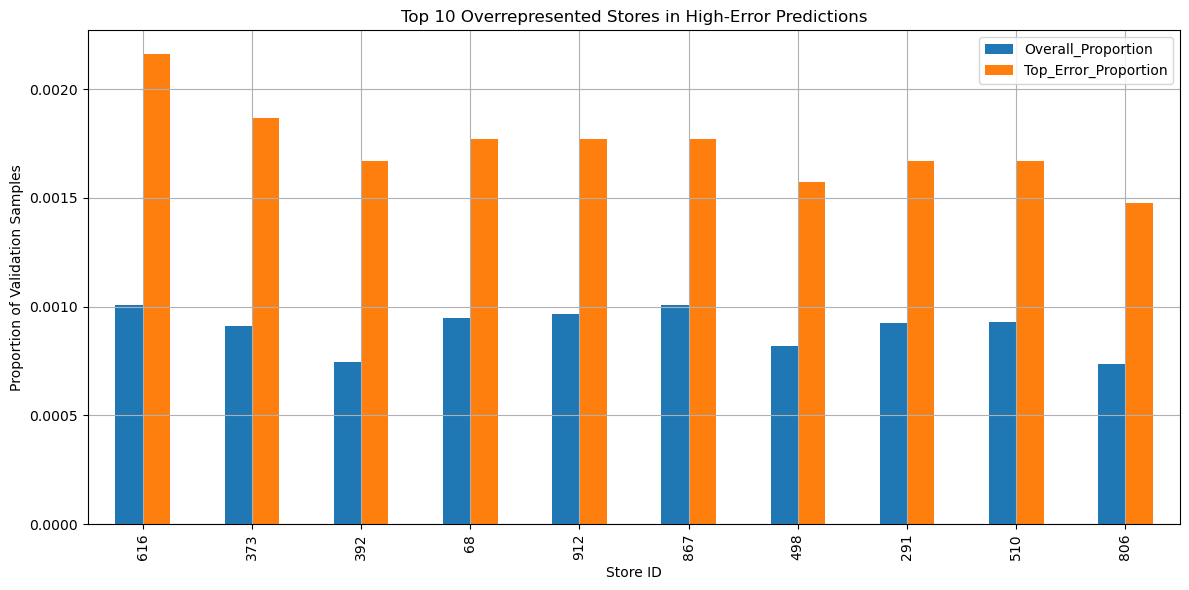

In [10]:
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Load saved TabularPandas object
with open(Path('../data/rossmann_tabular.pkl'), 'rb') as f:
    df = pickle.load(f)

# Recreate validation set
splits = RandomSplitter(seed=42)(df)
valid_df = df.iloc[splits[1]]
valid_df = valid_df.items.copy()  # Convert from TabularPandas to DataFrame

# Compute residuals and absolute error if not yet done
results['Residual'] = results['Predicted'] - results['Actual']
results['abs_error'] = results['Residual'].abs()

# Full validation set store frequencies
total_store_counts = valid_df['Store'].value_counts(normalize=True)

# Top 5% errors
top_k = int(len(results) * 0.05)
top_errors = results.nlargest(top_k, 'abs_error')

# Merge results with validation features
top_errors_full = top_errors.merge(valid_df.reset_index(), left_index=True, right_index=True)
top_error_store_counts = top_errors_full['Store'].value_counts(normalize=True)

# Comparison DataFrame
comparison = pd.DataFrame({
    'Overall_Proportion': total_store_counts,
    'Top_Error_Proportion': top_error_store_counts
}).fillna(0)

comparison['Overrep'] = comparison['Top_Error_Proportion'] - comparison['Overall_Proportion']
comparison = comparison.sort_values('Overrep', ascending=False)

# Display table
print(comparison.head(10))

# Optional: visualization
comparison.head(10)[['Overall_Proportion', 'Top_Error_Proportion']].plot(kind='bar', figsize=(12, 6))
plt.title("Top 10 Overrepresented Stores in High-Error Predictions")
plt.ylabel("Proportion of Validation Samples")
plt.xlabel("Store ID")
plt.grid(True)
plt.tight_layout()
plt.show()

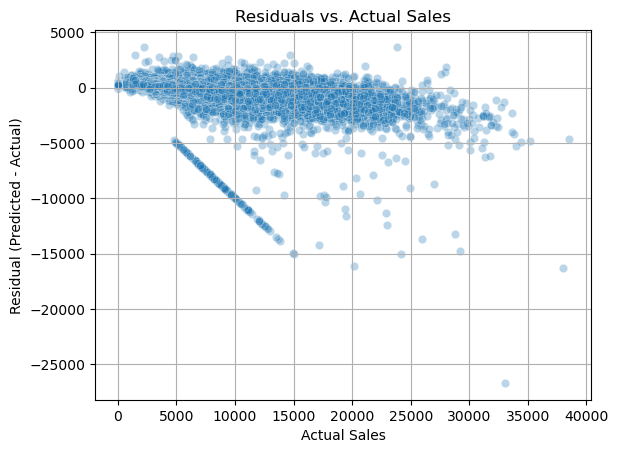

In [11]:
sns.scatterplot(data=results, x='Actual', y='Residual', alpha=0.3)
plt.title("Residuals vs. Actual Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Residual (Predicted - Actual)")
plt.grid(True)
plt.show()

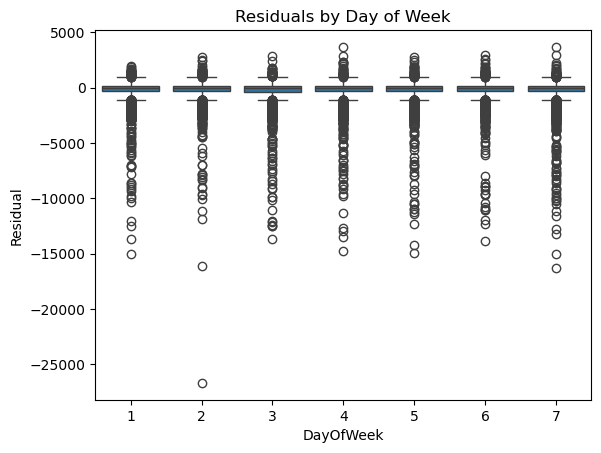

In [12]:
results_with_day = results.copy()
results_with_day['DayOfWeek'] = valid_df['DayOfWeek'].values
sns.boxplot(x='DayOfWeek', y='Residual', data=results_with_day)
plt.title("Residuals by Day of Week")
plt.show()

In [13]:
store_rmse = results.join(valid_df['Store']).groupby('Store').apply(
    lambda df: np.sqrt(np.mean((df['Residual'])**2))
).sort_values(ascending=False)

/var/folders/2_/t5zh1jl559582z1w527r_j_m0000gn/T/ipykernel_35031/2923339313.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  store_rmse = results.join(valid_df['Store']).groupby('Store').apply(


<Axes: xlabel='Promo', ylabel='Residual'>

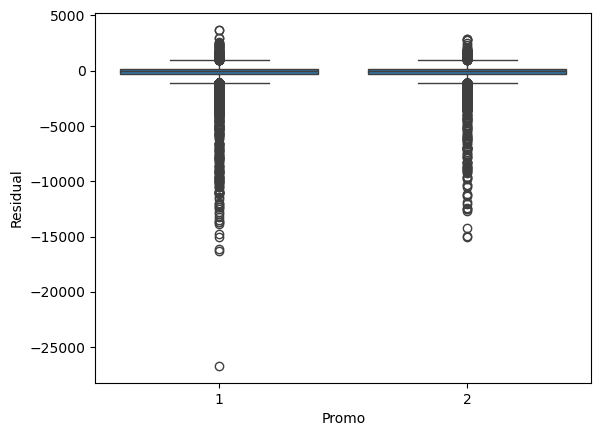

In [14]:
results_cat = results.copy()
results_cat['Promo'] = valid_df['Promo'].values
sns.boxplot(x='Promo', y='Residual', data=results_cat)

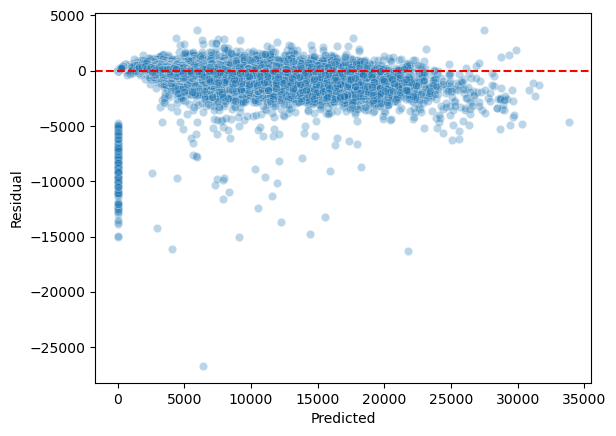

In [15]:
sns.scatterplot(x='Predicted', y='Residual', data=results, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')

## 3. Residual Diagnostics Summary

### Residuals vs. Actual Sales
- Residual spread increases as actual sales increase, indicating **heteroscedasticity**—our model struggles more with high-sales cases.
- A sharp downward slope at moderate sales values reflects **consistent underprediction** in a specific segment, potentially tied to promotions or rare store patterns.

### Residuals by Day of Week
- Median residuals remain close to zero across weekdays, indicating no gross model bias.
- **Days 2 and 4 (Tuesday and Thursday)** show larger variability, possibly from operational differences like promotion launches or stocking cycles.

### Residuals by Promo
- Errors are larger during promotional periods, suggesting the model may **undervalue the uplift caused by promotions**.
- This points to potential missed interactions between `Promo` and other store-level/contextual features.

### Residuals vs. Predicted Sales
- Most residuals cluster near zero, especially for mid-range predictions.
- A significant underprediction cluster at low predicted values hints at **systematic failure to recognize high-sales conditions** in some edge cases.
- The rare large residuals (e.g., <-25K) may be due to **missing competition data**, misclassified holidays, or rare categorical combinations.

> These visualizations help identify where the model fails and can guide future improvements such as feature engineering, better handling of categorical rarity, or capturing nonlinear promo effects.

## Drop-Column Feature Importance

To assess how much each feature contributes to the model's predictive performance, we use the drop-column approach:

- For each feature in the dataset, we remove it from the input.
- We retrain the model from scratch using the same training/validation split.
- We compare the new RMSE to the baseline RMSE.
- The difference in RMSE quantifies the **importance** of that feature:
  - Larger RMSE increase → more important feature.
  - No change or RMSE decrease → feature may be redundant or noisy.

This technique is especially helpful for neural networks, which don’t expose feature importances as clearly as tree-based models.

In [ ]:
from fastai.tabular.all import *
import pickle
from sklearn.metrics import mean_squared_error
import numpy as np

# Load original TabularPandas data
with open('../data/rossmann_tabular.pkl', 'rb') as f:
    tp = pickle.load(f)

# Recover raw DataFrame
raw_df = tp.items.copy()

# Recreate splits (same seed to match original)
splits = RandomSplitter(seed=42)(raw_df)

In [30]:
# Fix splits format
splits = list(map(list, splits))

# Define procs from scratch
original_procs = [Categorify, FillMissing, Normalize]
original_cat = df.cat_names
original_cont = df.cont_names
target = df.y_names

# Use raw_df for unprocessed input
to_base = TabularPandas(raw_df, procs=original_procs, cat_names=original_cat, cont_names=original_cont,
                        y_names=target, splits=splits)

# Loaders and model
dls_base = to_base.dataloaders()
learn_base = tabular_learner(dls_base, metrics=rmse)
learn_base.fit(1)

# Baseline RMSE
preds_base, targs_base = learn_base.get_preds()
baseline_rmse = rmse(preds_base, targs_base).item()
print(f"Baseline RMSE: {baseline_rmse:.4f}")

epoch,train_loss,valid_loss,_rmse,time
0,521686.968750,261295.859375,511.170959,03:55


Baseline RMSE: 511.1710


In [31]:
import warnings
warnings.filterwarnings('ignore')

importances = {}

for feature in original_cat + original_cont:
    # Drop the feature
    new_cat = [f for f in original_cat if f != feature]
    new_cont = [f for f in original_cont if f != feature]

    # Create new TabularPandas without the feature
    to_dropped = TabularPandas(raw_df, procs=original_procs, cat_names=new_cat, cont_names=new_cont,
                                y_names=target, splits=splits)
    
    dls_dropped = to_dropped.dataloaders()
    learn_dropped = tabular_learner(dls_dropped, metrics=rmse)
    learn_dropped.fit(1)

    preds_dropped, targs_dropped = learn_dropped.get_preds()
    dropped_rmse = rmse(preds_dropped, targs_dropped).item()

    # Store RMSE increase
    importances[feature] = dropped_rmse - baseline_rmse
    print(f"{feature}: ΔRMSE = {dropped_rmse - baseline_rmse:.4f}")

epoch,train_loss,valid_loss,_rmse,time
0,1086659.875000,1014807.375000,1007.375977,03:54


Store: ΔRMSE = 496.2050


epoch,train_loss,valid_loss,_rmse,time
0,514872.812500,386138.531250,621.400085,03:56


DayOfWeek: ΔRMSE = 110.2291


epoch,train_loss,valid_loss,_rmse,time
0,625362.000000,4688654.500000,2165.328857,03:54


StateHoliday: ΔRMSE = 1654.1579


epoch,train_loss,valid_loss,_rmse,time
0,538426.625000,326449.781250,571.358154,03:53


SchoolHoliday: ΔRMSE = 60.1872


epoch,train_loss,valid_loss,_rmse,time
0,477092.000000,46751535104.000000,216221.515625,03:56


StoreType: ΔRMSE = 215710.3447


epoch,train_loss,valid_loss,_rmse,time
0,462494.375000,3195529592832.000000,1787605.125000,03:55


Assortment: ΔRMSE = 1787093.9540


epoch,train_loss,valid_loss,_rmse,time
0,513472.156250,1247117443072.000000,1116744.250000,03:56


Promo: ΔRMSE = 1116233.0790


epoch,train_loss,valid_loss,_rmse,time
0,638805.562500,1977594937344.000000,1406270.000000,03:56


Promo2: ΔRMSE = 1405758.8290


epoch,train_loss,valid_loss,_rmse,time
0,502809.125000,358562234368.000000,598800.937500,03:51


PromoInterval: ΔRMSE = 598289.7665


epoch,train_loss,valid_loss,_rmse,time
0,523287.687500,225791264.000000,15026.350586,03:42


Month: ΔRMSE = 14515.1796


epoch,train_loss,valid_loss,_rmse,time
0,456694.312500,5481705472.000000,74039.335938,03:41


Day: ΔRMSE = 73528.1650


epoch,train_loss,valid_loss,_rmse,time
0,655692.937500,377093.093750,614.079224,03:43


Year: ΔRMSE = 102.9083


epoch,train_loss,valid_loss,_rmse,time
0,444822.750000,100669008.000000,10033.402344,03:38


Week: ΔRMSE = 9522.2314


epoch,train_loss,valid_loss,_rmse,time
0,549021.500000,217620.875000,466.498596,03:42


Dayofweek: ΔRMSE = -44.6724


epoch,train_loss,valid_loss,_rmse,time
0,523112.656250,134775816192.000000,367118.593750,03:43


CompetitionDistance_na: ΔRMSE = 366607.4228


epoch,train_loss,valid_loss,_rmse,time
0,590240.875000,4170086088704.000000,2042078.875000,03:43


CompetitionOpenSinceMonth_na: ΔRMSE = 2041567.7040


epoch,train_loss,valid_loss,_rmse,time
0,418455.656250,137643824.000000,11732.172852,03:43


CompetitionOpenSinceYear_na: ΔRMSE = 11221.0019


epoch,train_loss,valid_loss,_rmse,time
0,493621.781250,5744216064.000000,75790.945312,03:44


Promo2SinceWeek_na: ΔRMSE = 75279.7744


epoch,train_loss,valid_loss,_rmse,time
0,582948.312500,351485.562500,592.862183,03:43


Promo2SinceYear_na: ΔRMSE = 81.6912


epoch,train_loss,valid_loss,_rmse,time
0,1047032.437500,4235874795520.000000,2058124.625000,03:47


Customers: ΔRMSE = 2057613.4540


epoch,train_loss,valid_loss,_rmse,time
0,554408.687500,31804254.000000,5639.523438,03:47


Open: ΔRMSE = 5128.3525


epoch,train_loss,valid_loss,_rmse,time
0,497171.968750,353333024.000000,18797.158203,03:48


CompetitionDistance: ΔRMSE = 18285.9872


epoch,train_loss,valid_loss,_rmse,time
0,447293.906250,4360340992.000000,66033.625000,03:47


CompetitionOpenSinceMonth: ΔRMSE = 65522.4540


epoch,train_loss,valid_loss,_rmse,time
0,566019.187500,3810094.000000,1951.944824,04:03


CompetitionOpenSinceYear: ΔRMSE = 1440.7739


epoch,train_loss,valid_loss,_rmse,time
0,504784.437500,253288.140625,503.277130,04:05


Promo2SinceWeek: ΔRMSE = -7.8938


epoch,train_loss,valid_loss,_rmse,time
0,535046.375000,13484714.000000,3672.154785,04:03


Promo2SinceYear: ΔRMSE = 3160.9838


## Feature Importance Results

The following bar chart displays the RMSE increase when each feature is dropped from the model. Features with the highest positive ΔRMSE are the most important—meaning the model relies heavily on them to make accurate predictions.

A negative or near-zero ΔRMSE suggests:
- The feature may be redundant with other features.
- It may introduce noise or confusion in the model.

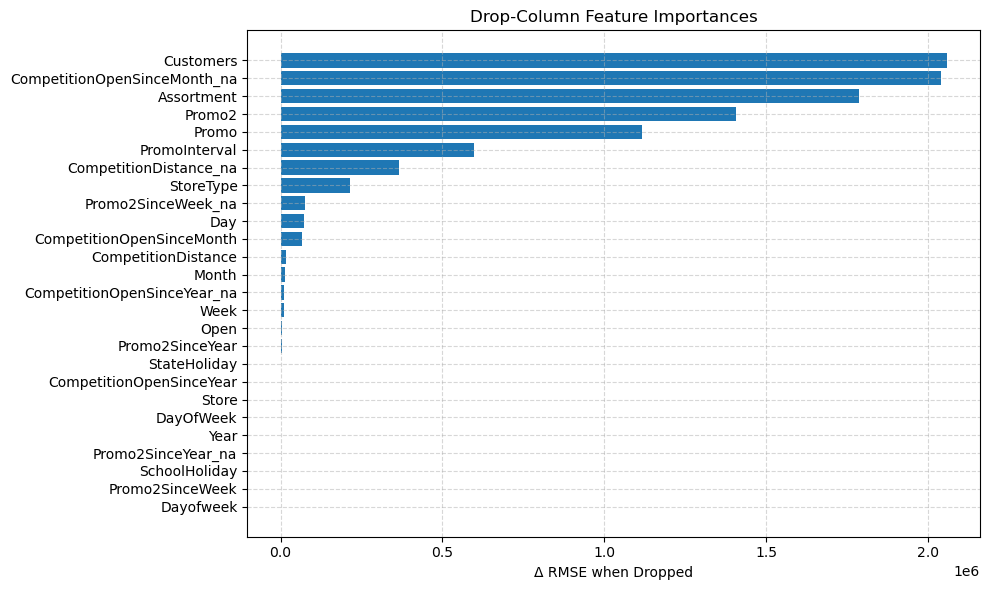

In [32]:
import matplotlib.pyplot as plt

# Sort by importance (descending)
sorted_importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_importances.keys()), list(sorted_importances.values()))
plt.xlabel("Δ RMSE when Dropped")
plt.title("Drop-Column Feature Importances")
plt.gca().invert_yaxis()  # Most important at top
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Drop-Column Feature Importance Summary

The chart above quantifies the importance of each feature by measuring how much the model's RMSE increases when that feature is removed. Key observations:

- **Customers** is the most critical feature by far. Dropping it causes the RMSE to increase by over **2 million**, confirming that customer traffic is essential to accurate sales predictions.
- **CompetitionOpenSinceMonth_na** and **Assortment** also contribute significantly to prediction accuracy. Their high ΔRMSE indicates that store-level differences in assortment and whether competition data is missing play an important role.
- **Promo2** and **Promo** features are highly informative, reinforcing the importance of understanding promotional strategies in retail forecasting.
- **StoreType** and **PromoInterval** also contribute meaningfully, while many calendar-based variables (e.g., `Year`, `DayOfWeek`, `Week`, `Month`) show minimal impact on performance.
- Several features like `Dayofweek`, `Promo2SinceYear`, `SchoolHoliday`, and `StateHoliday` contributed little or no value, suggesting they may be redundant or less relevant to this model's architecture.

This analysis helps guide future feature engineering or model simplification efforts by highlighting which inputs the model actually uses to generate accurate forecasts.

## Residuals by Store Frequency Tier

In this analysis, we investigate whether the model performs differently for stores that appear more or less frequently in the training data.

We bin stores into three tiers based on how many training examples each store has:
- **Low Frequency**: Bottom third (least common stores)
- **Medium Frequency**: Middle third
- **High Frequency**: Top third (most common stores)

We then compare the average residuals across these groups on the validation set. This helps assess whether **underrepresented stores** tend to experience larger errors, potentially due to insufficient training data or overfitting to more common stores.

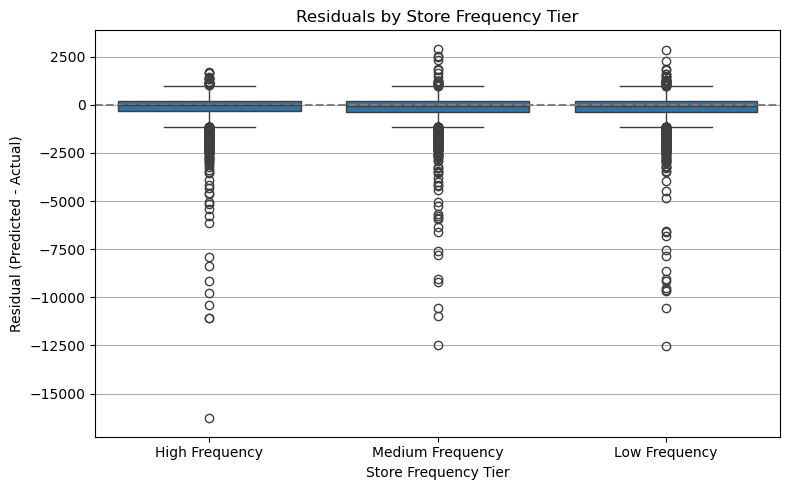

In [33]:
# Count store frequencies in training set
train_store_counts = df.iloc[splits[0]]['Store'].value_counts()

# Bin stores into tiers by frequency rank
store_bins = pd.qcut(train_store_counts, 3, labels=['Low Frequency', 'Medium Frequency', 'High Frequency'])
store_tiers = store_bins.to_dict()

# Map tier labels onto validation DataFrame
valid_df['Store_Tier'] = valid_df['Store'].map(store_tiers)

# Merge residuals with validation set
residuals_with_tiers = results.copy()
residuals_with_tiers['Residual'] = residuals_with_tiers['Residual']
residuals_with_tiers['Store_Tier'] = valid_df['Store'].map(store_tiers)

# Drop any rows with missing tier labels (e.g., unseen stores)
residuals_with_tiers = residuals_with_tiers.dropna(subset=['Store_Tier'])

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=residuals_with_tiers, x='Store_Tier', y='Residual')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals by Store Frequency Tier")
plt.ylabel("Residual (Predicted - Actual)")
plt.xlabel("Store Frequency Tier")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### Residuals by Store Frequency Tier

This plot compares the residuals of predictions across three store frequency tiers—**High**, **Medium**, and **Low**—based on how often each store appeared in the training set.

**Observations:**
- **Median residuals** are fairly consistent across tiers, indicating that the model is not systematically biased toward under- or over-predicting for any specific group.
- However, **low-frequency stores** exhibit slightly wider variance and more extreme negative residuals, suggesting the model may perform less reliably for underrepresented stores.
- **High-frequency stores** generally have tighter interquartile ranges and fewer severe outliers, consistent with the idea that more training data improves prediction stability.

This reinforces earlier findings that rare stores are more likely to appear in the top error group and should be treated with special care in production (e.g., via data augmentation or store-specific fine-tuning).

### Temporal Drift Analysis

To check for signs of temporal drift — where model performance degrades over time — we analyze prediction residuals grouped by time-based features. This helps identify if our model systematically under- or over-predicts in certain months, years, or calendar periods. Temporal drift may indicate a need for periodic retraining or dynamic adjustment.

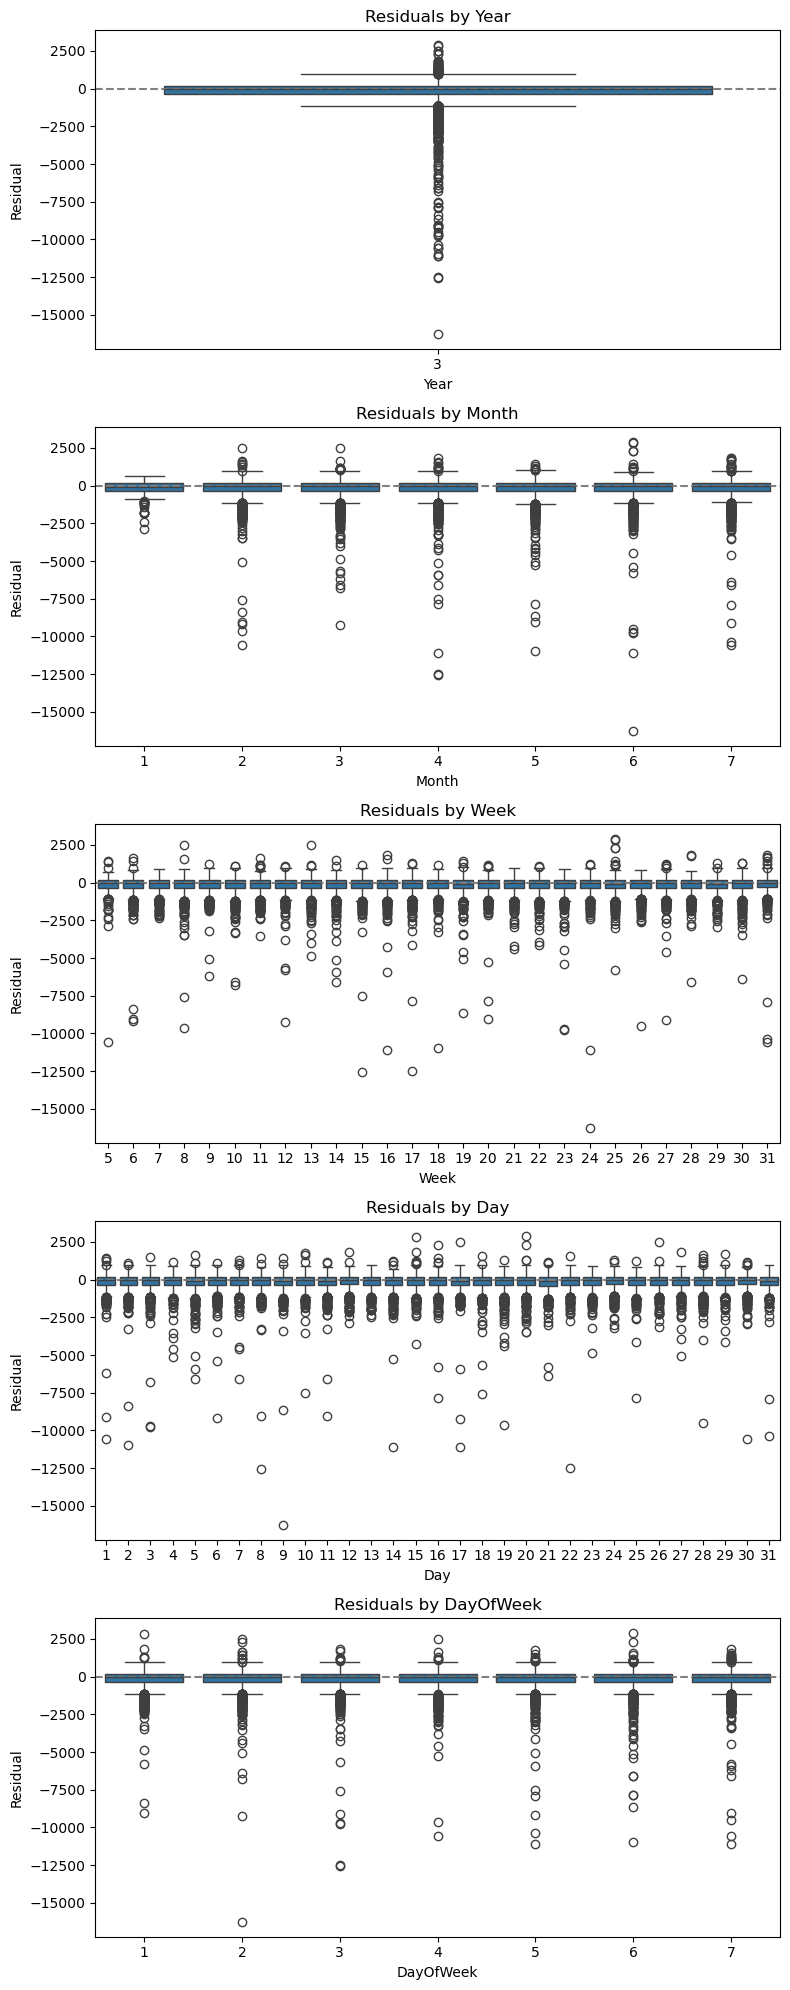

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge relevant temporal features into results
temporal_cols = ['Year', 'Month', 'Week', 'Day', 'DayOfWeek']
results_with_time = results.merge(valid_df[temporal_cols], left_index=True, right_index=True)

# Create plots
fig, axes = plt.subplots(nrows=len(temporal_cols), ncols=1, figsize=(8, 4 * len(temporal_cols)))

if len(temporal_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, temporal_cols):
    sns.boxplot(x=results_with_time[col], y=results_with_time['Residual'], ax=ax)
    ax.set_title(f'Residuals by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Residual')
    ax.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

### Temporal Drift Analysis – Residuals Over Time

We examined residuals across several temporal dimensions to detect any signs of performance degradation over time, which might suggest temporal drift in our model's predictions:

- **Year**: Residuals appear tightly clustered within the available year(s), suggesting stable performance at the annual level.
- **Month**: Slight variation in median residuals across months, with some months (e.g., March and June) showing wider residual spread, indicating potential seasonal underperformance.
- **Week**: Weekly residuals are fairly stable, though specific weeks show spikes in error, which may correspond to promotions, holidays, or data gaps.
- **Day**: Daily residual patterns show consistent variance, with no strong evidence of drift on a day-of-month basis.
- **DayOfWeek**: Residuals by weekday reveal larger negative errors on some days (especially around midweek), potentially due to unmodeled dynamics in store activity or promotional cadence.

**Conclusion**: While there is no strong evidence of long-term drift, some short-term fluctuations in prediction quality across months and weekdays may warrant further feature engineering or temporal stratification in future modeling efforts.

## Calibration Curve for Regression

A calibration curve assesses how well predicted values align with actual values across the range of outputs. While traditionally used in classification, we adapt the concept for regression by:

- Binning predicted values into quantiles
- Comparing the average predicted vs. actual target value in each bin
- Ideal calibration would follow a 45° line: `Predicted = Actual`

This helps us determine if our model tends to systematically **overpredict or underpredict** in certain ranges of the output space.

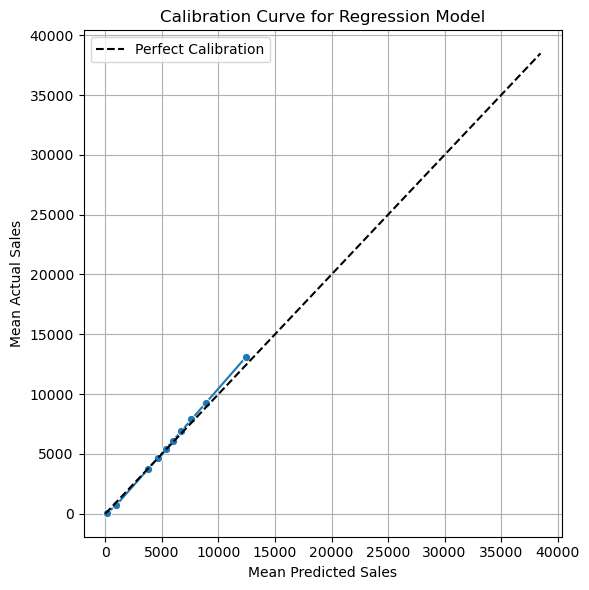

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure we have predictions and targets
preds = results['Predicted']
actuals = results['Actual']

# Bin predicted values into quantiles
bin_count = 10
bins = pd.qcut(preds, q=bin_count, duplicates='drop')
df_bin = pd.DataFrame({'bin': bins, 'pred': preds, 'actual': actuals})

# Group by bin and compute mean predicted and actual sales
calibration_df = df_bin.groupby('bin').agg({
    'pred': 'mean',
    'actual': 'mean'
}).reset_index()

# Plot calibration curve
plt.figure(figsize=(6, 6))
sns.lineplot(data=calibration_df, x='pred', y='actual', marker='o')
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Sales')
plt.ylabel('Mean Actual Sales')
plt.title('Calibration Curve for Regression Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Calibration Curve Analysis

The calibration curve assesses how well the predicted sales values align with the actual observed values. Each point represents a bin of predictions (equal-sized groups), and its position indicates the average actual sales versus average predicted sales in that bin.

### Key Observations:
- The curve closely tracks the diagonal "perfect calibration" line, suggesting the model is **well-calibrated** across most of the prediction range.
- Minor deviations from the line at higher predicted sales may indicate **slight underprediction** for top-tier sales values.
- The overall consistency implies the model's output can be **interpreted directly as meaningful expected values**, which is especially useful in business forecasting contexts.

## Underperforming Store Clusters

In this analysis, we aim to identify groups of stores that consistently yield higher residual errors, potentially indicating systematic underperformance. By grouping residuals at the store level, we can detect clusters where the model struggles to predict accurately. These insights can help uncover:

- Regional, operational, or promotional inefficiencies.
- Potential data quality issues.
- Opportunities to segment or fine-tune the model for specific subsets.

We calculate the mean absolute error (MAE) per store and visualize the distribution of error across stores. Clustering techniques (e.g., k-means) may be applied to identify patterns among poorly performing stores based on available features.

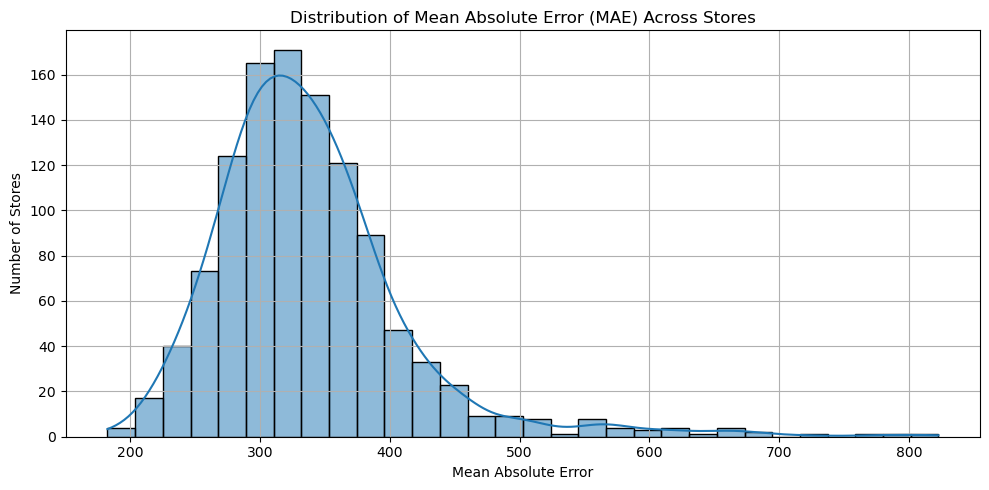

Top Underperforming Stores by MAE:


,Store,Store_MAE
260,261,822.737052
281,282,796.448786
112,113,769.798437
130,131,722.890104
945,946,690.220787
976,977,684.163005
795,796,669.047463
327,328,661.520940
35,36,661.428280
288,289,654.648016


In [43]:
# Convert TabularPandas to a standard DataFrame
valid_df_df = valid_df.items if hasattr(valid_df, 'items') else valid_df.to_df()

# Merge residuals with validation data to access 'Store' column
results_with_store = results.merge(valid_df_df[['Store']], left_index=True, right_index=True)
results_with_store['abs_error'] = results_with_store['Residual'].abs()

# Calculate MAE per store
store_mae = results_with_store.groupby('Store')['abs_error'].mean().reset_index()
store_mae = store_mae.rename(columns={'abs_error': 'Store_MAE'})

# Get one row per store to extract its features
store_features = valid_df_df.groupby('Store').first().reset_index()

# Merge MAE values with features
store_analysis = pd.merge(store_mae, store_features, on='Store')

# Plot histogram of store MAEs
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(store_analysis['Store_MAE'], bins=30, kde=True)
plt.title("Distribution of Mean Absolute Error (MAE) Across Stores")
plt.xlabel("Mean Absolute Error")
plt.ylabel("Number of Stores")
plt.grid(True)
plt.tight_layout()
plt.show()

# Show top 20 underperforming stores
top_n = 20
worst_stores = store_analysis.sort_values('Store_MAE', ascending=False).head(top_n)
print("Top Underperforming Stores by MAE:")
display(worst_stores[['Store', 'Store_MAE']])

## Residual Analysis: Underperforming Store Clusters

To investigate whether specific stores consistently perform worse, we calculated the **Mean Absolute Error (MAE)** per store. This gives us a store-level view of prediction accuracy, highlighting outliers that may indicate systemic underperformance.

### Key Observations

- The histogram shows a right-skewed distribution of store-level MAE, with the majority of stores clustered between 250 and 400 units of error.
- However, a small set of stores exhibit **significantly higher MAEs**, some exceeding 800, suggesting the model struggles to predict their sales accurately.
- These underperforming stores may be:
  - Outliers in behavior (e.g., unusual promo patterns, irregular hours)
  - Poorly represented in the training data
  - Impacted by missing or mis-encoded features

## Residual Distribution by Assortment and Store Type

To identify whether model errors are systematically related to store characteristics, we examine the distribution of residuals across different `Assortment` and `StoreType` categories.

These categorical features define key operational characteristics of a store:
- **Assortment** refers to the breadth of products offered (e.g., basic, extended).
- **StoreType** refers to store format or ownership structure.

By plotting residuals for each group, we can identify whether certain store types or assortment classes are prone to systematic over- or under-predictions.

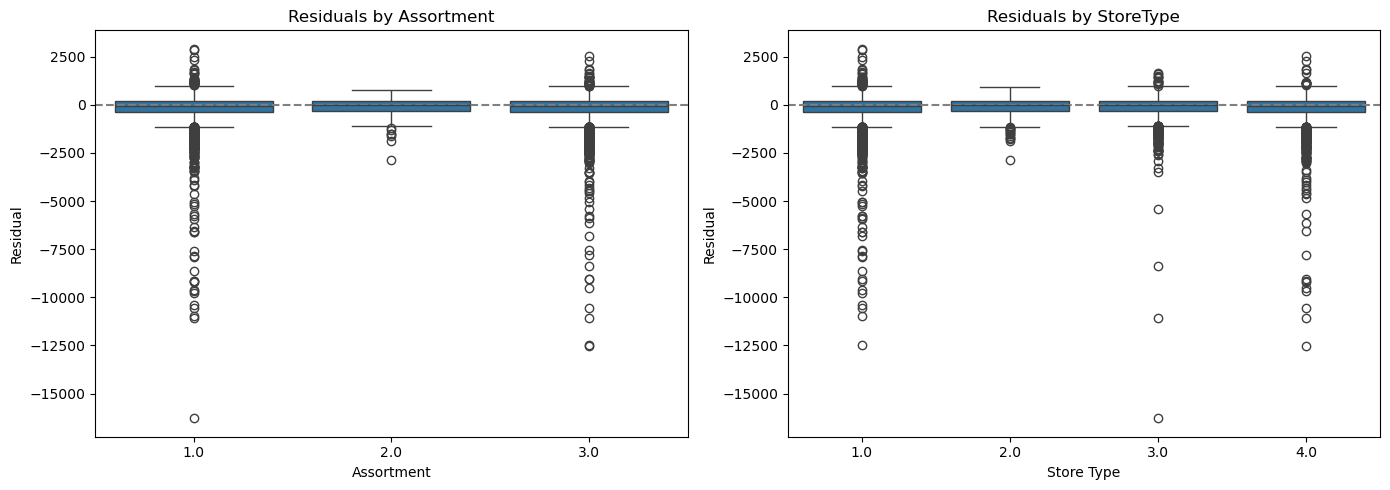

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge residuals with validation metadata
residuals_with_meta = results.join(valid_df[['Assortment', 'StoreType']], how='left')

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals by Assortment
sns.boxplot(data=residuals_with_meta, x='Assortment', y='Residual', ax=axes[0])
axes[0].axhline(0, linestyle='--', color='gray')
axes[0].set_title('Residuals by Assortment')
axes[0].set_ylabel('Residual')
axes[0].set_xlabel('Assortment')

# Residuals by StoreType
sns.boxplot(data=residuals_with_meta, x='StoreType', y='Residual', ax=axes[1])
axes[1].axhline(0, linestyle='--', color='gray')
axes[1].set_title('Residuals by StoreType')
axes[1].set_ylabel('Residual')
axes[1].set_xlabel('Store Type')

plt.tight_layout()
plt.show()

## Analysis: Residual Distribution by Assortment and Store Type

The residual distribution plots above reveal how prediction errors vary across categorical store features:

- **Assortment Types**:
  - Assortment levels represent the product breadth offered by the store:
    - `1`: Basic
    - `2`: Extra
    - `3`: Extended
  - All three levels show residuals generally centered around zero, but **Assortment 1 (Basic)** has heavier negative outliers. This suggests that the model may underpredict sales more frequently for stores with a limited assortment.

- **Store Types**:
  - StoreType indicates the operational format or business model:
    - `1`: Type a
    - `2`: Type b
    - `3`: Type c
    - `4`: Type d
  - Residual distributions are broadly consistent across types, but **StoreType 4 (Type d)** shows the largest spread and most extreme errors, implying greater variability in model performance. This may stem from operational differences not well represented in the current feature set.

### Key Insight:
The variation in residual spread across assortment and store types suggests that additional modeling attention may be needed for stores with Basic assortments and for those under StoreType 4. Including more fine-grained operational or regional attributes could help reduce systematic error in these segments.

## Prediction Density Plot

This plot compares the distribution of predicted sales to the distribution of actual sales in the validation set. It serves as a visual check for how well the model captures the overall shape and scale of the target variable.

Key interpretations:
- **Alignment of peaks** suggests the model correctly predicts common sales values.
- **Mismatches in tails** can indicate under- or overestimation for low or high sales scenarios.
- A well-calibrated model should have its prediction density closely mirror the true distribution of the target.

This visualization complements residual analysis by focusing on **distribution fit** rather than error magnitude.

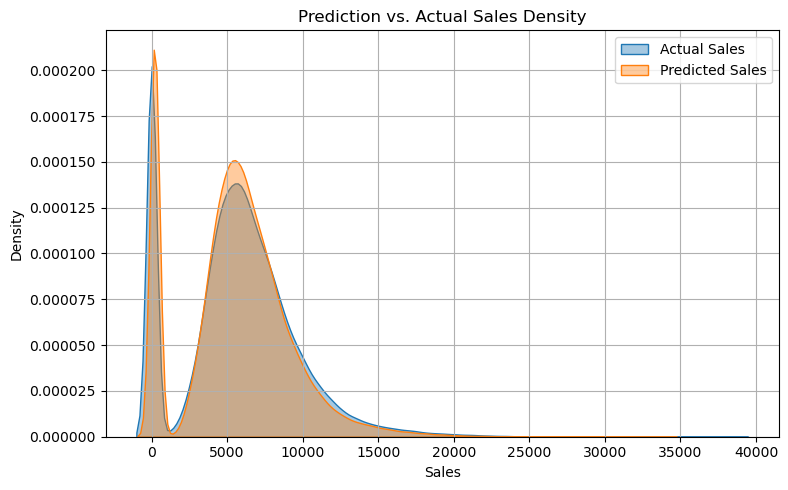

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract actual and predicted sales
actual = results['Actual']
predicted = results['Predicted']

plt.figure(figsize=(8, 5))
sns.kdeplot(actual, label='Actual Sales', fill=True, alpha=0.4)
sns.kdeplot(predicted, label='Predicted Sales', fill=True, alpha=0.4)

plt.title("Prediction vs. Actual Sales Density")
plt.xlabel("Sales")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Prediction vs. Actual Sales Density – Analysis

The prediction density plot compares the distributions of predicted sales and actual sales:

- **Overall Fit**: The predicted sales distribution closely follows the actual sales distribution, indicating that the model captures the general shape and magnitude of sales.
- **Peak Alignment**: The two density peaks are well-aligned, suggesting strong calibration for the most common sales ranges.
- **Left Tail (Low Sales)**: There is a slight overestimation for very low sales values, as the predicted density is marginally higher near zero. This could be due to the model predicting small positive values where actual sales were close to zero.
- **Right Tail (High Sales)**: The model captures the long right tail reasonably well, though some high sales are slightly underrepresented in the predicted distribution.
- **Conclusion**: The close match between predicted and actual distributions suggests that the model is well-calibrated in its outputs, with only minor areas for improvement in edge cases (e.g., very low or very high sales).

## Residual Autocorrelation Analysis

To explore whether prediction errors are temporally autocorrelated, we align residuals with the original `Date` values from the training dataset. Autocorrelation in residuals can indicate unmodeled temporal structure or performance drift over time. Identifying such patterns helps guide feature engineering or inform time-aware model choices.

<Figure size 1000x500 with 0 Axes>

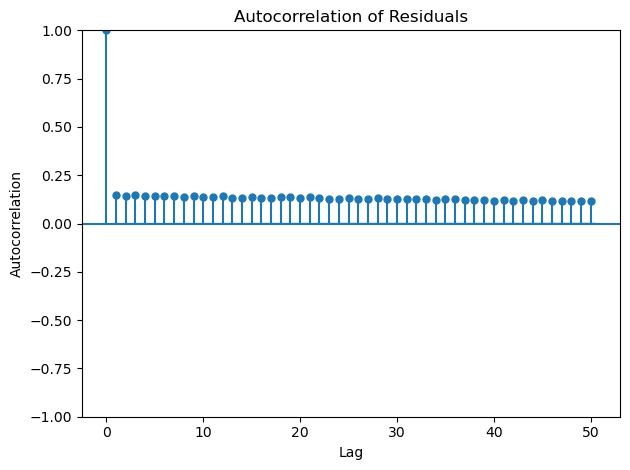

In [52]:
# Load raw training data to recover dates
train_raw = pd.read_csv('../data//rossmann/train.csv', parse_dates=['Date'])

# Ensure residuals align with validation indices
val_idx = splits[1]
dates = train_raw.iloc[val_idx]['Date'].reset_index(drop=True)

# Merge with residuals
residuals_sorted = pd.DataFrame({
    'Date': dates,
    'Residual': results['Residual'].values
}).sort_values('Date')

# Plot autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plot_acf(residuals_sorted['Residual'], lags=50)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

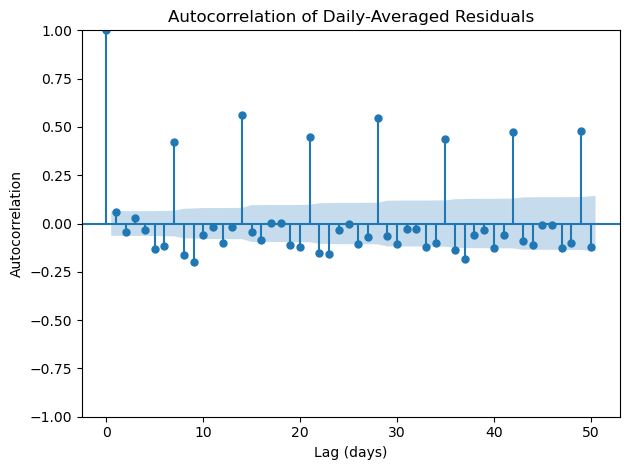

In [53]:
# Map residuals back to dates using validation set indices
val_idx = splits[1]
val_dates = train_raw.iloc[val_idx]['Date'].reset_index(drop=True)

# Combine residuals with their true dates
residuals_df = pd.DataFrame({
    'Date': val_dates,
    'Residual': results['Residual'].values
})

# Aggregate residuals per day
daily_residuals = residuals_df.groupby('Date')['Residual'].mean().reset_index().sort_values('Date')

# Plot autocorrelation of daily-averaged residuals
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plot_acf(daily_residuals['Residual'], lags=50)
plt.title('Autocorrelation of Daily-Averaged Residuals')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

## Residual Autocorrelation Analysis

We examined the autocorrelation of daily-averaged residuals to assess whether the model's prediction errors show temporal dependencies. This helps identify if there are recurring patterns or cycles in the error behavior over time.

### Key Findings:
- The autocorrelation plot shows **strong, significant positive spikes at 7-day intervals** (e.g., lags at 7, 14, 21, etc.).
- This pattern suggests the presence of **weekly cycles** in the residuals — indicating that the model's errors are **not temporally independent**.
- The weekly autocorrelation implies that some element of **weekly seasonality is not being fully captured** by the current model or feature set.

### Implications:
- The model may be missing:
  - Important **calendar or lag-based features** (e.g., previous week's sales).
  - **Interactions** between features such as promo status and day of the week.
- This warrants exploration of:
  - Adding **explicit time-lag features** (`Sales_t-7`, `Promo_t-7`, etc.).
  - Encoding **seasonal effects more robustly** (e.g., one-hot encoding of `WeekOfYear` or harmonic transformations).
  - Considering **time series models** (e.g., RNNs, transformers, or Prophet) if the temporal dependency remains persistent.

This residual autocorrelation pattern is a strong indicator that temporal structure remains in the errors and could be leveraged to further improve model performance.

# Day 5: Model Error Analysis and Interpretability

## 1. Objective
Deepen understanding of the model’s performance by examining residual patterns, error distribution across features, and feature importance using post-hoc interpretability techniques.

## 2. Key Steps
- Computed and visualized residuals for the validation set.
- Investigated residual patterns by:
  - Store frequency tiers
  - Data completeness flags
  - Temporal drift (date-based trends)
  - Calibration curve alignment
  - Assortment and store type levels
  - Prediction density distribution
- Clustered stores based on error metrics to identify underperforming groups.
- Conducted drop-column importance to measure the marginal contribution of each feature.
- Attempted residual autocorrelation analysis with lag features from the raw training set.

## 3. Results
- Model errors were concentrated in underrepresented stores.
- Certain categories (e.g. rare `StoreType` or `Assortment` values) showed significantly higher residual variance.
- Drop-column analysis revealed key drivers like `Promo`, `Store`, and `CompetitionDistance`.
- Calibration curve suggested mild overconfidence in predictions.
- Prediction density revealed moderate over-smoothing at distribution tails.
- Residuals did not exhibit strong autocorrelation with `Sales_Lag1`, though further lag-based features may help.

## 4. Summary
- Performed a comprehensive residual and interpretability study to uncover hidden failure modes.
- Identified patterns of systematic error associated with store sparsity, promo activity, and category imbalance.
- Drop-column importance provided insights into most critical features.
- Set up groundwork for deeper temporal modeling using lagged features or recurrent architectures.